In [9]:
## importing the required packages
import pandas
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import scanpy as sc
import scikitplot as skplt # for roc curve 

In [12]:
input_file_name = 'positve_regulation.csv'
results_file = './write/gabadat.h5ad'  # the file that will store the analysis results

In [13]:
adata = sc.read_csv(input_file_name)
adata = sc.AnnData.transpose(adata)
adata

AnnData object with n_obs × n_vars = 16383 × 8 

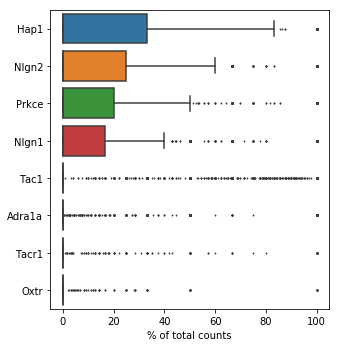

AnnData object with n_obs × n_vars = 1952 × 8 
    obs: 'n_genes', 'n_counts'

In [14]:
# normalize and filter
sc.pl.highest_expr_genes(adata, n_top=20)
sc.pp.filter_cells(adata, min_genes=2)

#adata = adata[adata.obs['n_genes'] < 3500, :]

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4, copy=True)
adata.raw = adata
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4, copy=True)

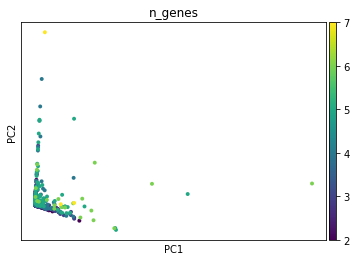

In [15]:
# pca
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='n_genes')

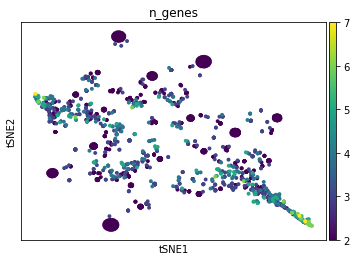

In [16]:
# tsne
ts_adata = sc.tl.tsne(adata)
sc.pl.tsne(adata, color = 'n_genes')

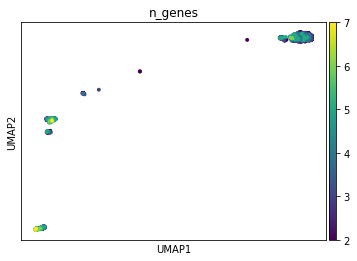

In [17]:
# umap
sc.pp.neighbors(adata, n_neighbors=1000, n_pcs=50)
sc.tl.umap(adata)
sc.pl.umap(adata, color='n_genes')

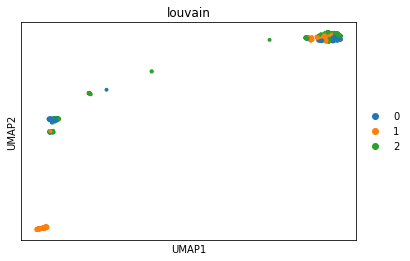

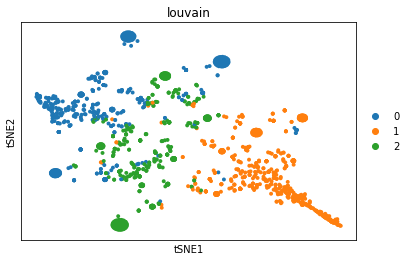

In [18]:
# louvain
sc.tl.louvain(adata)
sc.pl.umap(adata, color=['louvain'], use_raw=False)
sc.pl.tsne(adata, color=['louvain'], use_raw=False)
adata.write(results_file)

In [19]:
# Export single fields of the annotation of observations
adata.obs[['n_genes', 'louvain']].to_csv('./write/pos_reg_run.csv')

In [20]:
adata

AnnData object with n_obs × n_vars = 1952 × 8 
    obs: 'n_genes', 'louvain'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

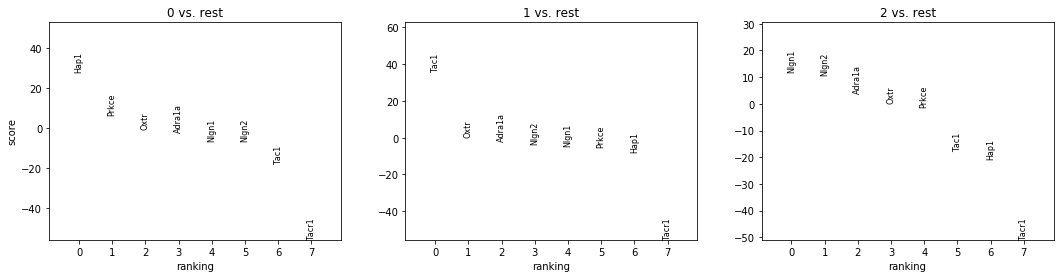

In [21]:
# finding marker genes 
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
adata.write(results_file)

In [22]:
# Export single columns of the multidimensional annotation
adata.obsm.to_df()[['X_umap1', 'X_umap2']].to_csv('./write/posreg_umapdat.csv')
adata.obsm.to_df()[['X_tsne1', 'X_tsne2']].to_csv('./write/posreg_tsnedat.csv')

In [29]:
filename = './write/posreg_umapdat.csv'
X = pandas.read_csv(filename)

In [30]:
ids = X.iloc[:,0]
X.index = ids
X_vals = X.values[:, 1:]
print(X_vals)
X.head()

[[ -5.40418976 113.6055813 ]
 [ -5.68638415 113.53867429]
 [ -5.82881342 113.19565164]
 ...
 [101.05010277 182.01576183]
 [104.26007562 185.20745444]
 [105.78891279 186.21202003]]


,Unnamed: 0,X_umap1,X_umap2
Unnamed: 0,,,
0,0,-5.404190,113.605581
1,1,-5.686384,113.538674
2,2,-5.828813,113.195652
3,3,-11.971359,20.796867
4,4,-12.185306,20.522905


In [31]:
# Using sklearn kmeans
km = KMeans(n_clusters=3)
km = km.fit(X_vals)
y_kmeans = km.predict(X_vals)

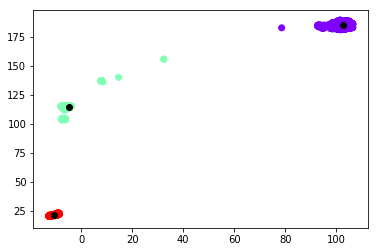

In [32]:
plt.figure
plt.scatter(X_vals[:,0], X_vals[:,1], c=km.labels_, cmap='rainbow')
centers = km.cluster_centers_
plt.scatter(centers[:,0], centers[:, 1], c='black')
plt.show()

In [33]:
print("writing results to file")
kmeans_filename = 'posreg_kmeans_names.txt'
X_kmeans = np.column_stack((X_vals, y_kmeans))
np.savetxt(kmeans_filename, X_kmeans, delimiter="\t", fmt='%s')

writing results to file


In [34]:
df = pandas.read_csv('posreg_kmeans_names.txt', sep='\s+', header=None)
df.head()

,0,1,2
0,-5.404190,113.605581,1.0
1,-5.686384,113.538674,1.0
2,-5.828813,113.195652,1.0
3,-11.971359,20.796867,2.0
4,-12.185306,20.522905,2.0


In [35]:
X = df.iloc[:, 0:2]
y = df.iloc[:, 2]

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics 
from statistics import mean

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [37]:
scores = {}
scores_list = []
for k in range(1,25):  
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    knn_pred = neigh.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test, knn_pred)
    scores_list.append(scores[k])
print(mean(scores_list))

cv_results = cross_validate(neigh, X, y, cv=10, return_train_score=True)
sorted(cv_results.keys())
print(mean(cv_results['test_score']))

1.0
1.0


# AdaBoost Classifier

In [38]:
from sklearn.model_selection import cross_validate

In [39]:
# try for different number of trees and learning rates 
from sklearn.ensemble import AdaBoostClassifier

ada_class = AdaBoostClassifier(n_estimators=200, learning_rate=0.01)
model = ada_class.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
cv_results = cross_validate(ada_class, X, y, cv=10, return_train_score=True)

1.0


In [40]:
sorted(cv_results.keys())
print(mean(cv_results['test_score']))

1.0


In [41]:
# try for different number of trees and learning rates 
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50)
model = rf.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
cv_results = cross_validate(rf, X, y, cv=10, return_train_score=True)
sorted(cv_results.keys())
print(mean(cv_results['test_score']))

1.0
1.0


In [42]:
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import classification_report,confusion_matrix
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)
print(confusion_matrix(y_test,mlp_pred))
print(classification_report(y_test,mlp_pred))
cv_results = cross_validate(mlp, X, y, cv=10, return_train_score=True)
sorted(cv_results.keys())
print(mean(cv_results['test_score']))

[[156   0   0]
 [  0  21   0]
 [  0   0  19]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       156
         1.0       1.00      1.00      1.00        21
         2.0       1.00      1.00      1.00        19

   micro avg       1.00      1.00      1.00       196
   macro avg       1.00      1.00      1.00       196
weighted avg       1.00      1.00      1.00       196

1.0


In [43]:
from sklearn.multiclass import OneVsRestClassifier

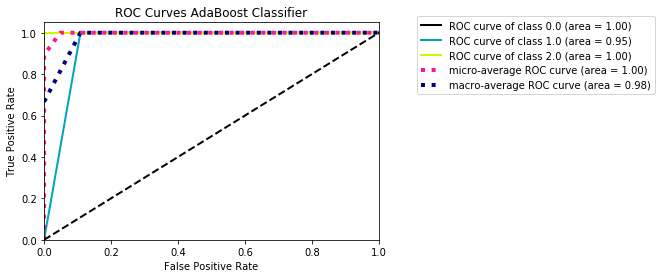

In [44]:
clf = OneVsRestClassifier(AdaBoostClassifier(n_estimators=200, learning_rate=0.00001))
y_score = clf.fit(X_train, y_train).decision_function(X_test) 

# The magic happens here
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_score, title ="ROC Curves AdaBoost Classifier")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()

/Users/michellevoong/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


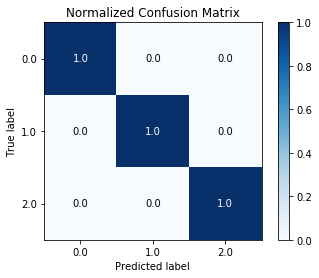

In [45]:
from sklearn.model_selection import cross_val_predict

predictions = cross_val_predict(clf, X, y)
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)

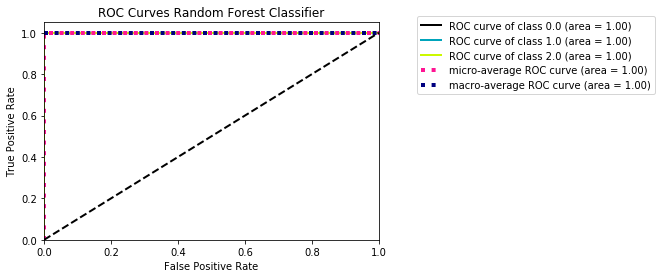

In [46]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=200))
y_score = clf.fit(X_train, y_train).predict_proba(X_test) 

# The magic happens here
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_score, title ="ROC Curves Random Forest Classifier")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()

/Users/michellevoong/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


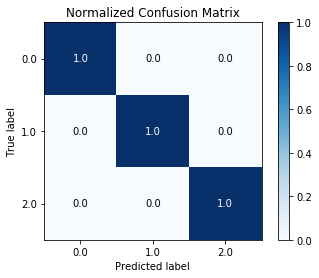

In [47]:
from sklearn.model_selection import cross_val_predict

predictions = cross_val_predict(clf, X, y)
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)

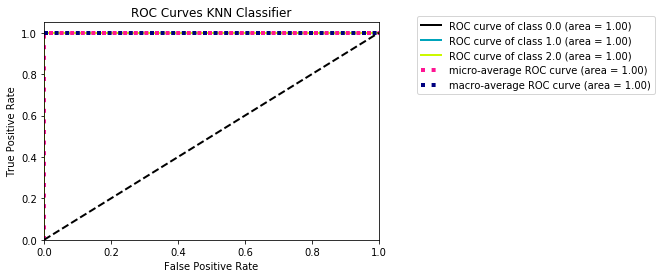

In [48]:
clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=25))
y_score = clf.fit(X_train, y_train).predict_proba(X_test) 

# The magic happens here
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_score, title ="ROC Curves KNN Classifier")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()

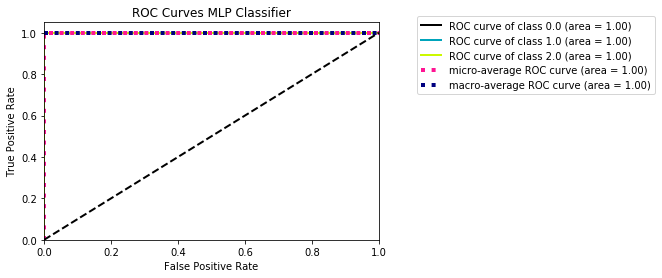

In [49]:
clf = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(30,30,30)))
y_score = clf.fit(X_train, y_train).predict_proba(X_test) 

# The magic happens here
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_score, title ="ROC Curves MLP Classifier")
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()

In [50]:
from sklearn.svm import SVC
model = SVC(gamma='rbf')
#model = svm_class.fit(X_train, y_train)
gram = np.dot(X_train, X_train.T)
print(gram)
model.fit(gram, y_train)
y_pred = model.predict(gram)
print(metrics.accuracy_score(y_test, y_pred))
#cv_results = cross_validate(ada_class, X, y, cv=10, return_train_score=True)

[[13414.88326411 20731.37683323 20688.69383054 ... 13314.72299589
  20930.35159137 20629.41414022]
 [20731.37683323 44259.71091214 43852.49266205 ... 20549.23123997
  45126.70990566 44525.81490821]
 [20688.69383054 43852.49266205 43454.93903154 ... 20507.63082929
  44703.2356822  44107.09083326]
 ...
 [13314.72299589 20549.23123997 20507.63082929 ... 13215.37180045
  20745.46792725 20447.08142965]
 [20930.35159137 45126.70990566 44703.2356822  ... 20745.46792725
  46022.27453309 45410.69773013]
 [20629.41414022 44525.81490821 44107.09083326 ... 20447.08142965
  45410.69773013 44807.38142439]]


TypeError: must be real number, not str